In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

2023-12-29 17:25:26.308859: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 17:25:28.777565: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 17:25:28.777670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 17:25:29.116182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 17:25:29.890346: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 17:25:29.893333: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
att=["cycle","temperature_measured","capacity","current_load"]
dataset[["Soh"]]=dataset[["capacity"]]/2

In [3]:
Soh=dataset["capacity"]/dataset["capacity"][0]
time=dataset[["time"]]

In [4]:
# normalising data
dataset=dataset[["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load"]]
df_norm = (dataset-dataset.min())/(dataset.max()-dataset.min())
df_norm["time"]=time
df_norm["Soh"]=Soh

In [5]:
att_=["cycle","capacity","voltage_measured","current_measured","temperature_measured","current_load","voltage_load","time"]
att=["cycle","temperature_measured","capacity","current_load"]

In [6]:
X = df_norm[att]
Y = df_norm[["Soh"]]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [8]:
#sorting data wrt to index
X_test = X_test.sort_index(axis=0)
X_train= X_train.sort_index(axis=0)
y_train= y_train.sort_index(axis=0)
y_test = y_test.sort_index(axis=0)

In [27]:
#define lstm model we have 4 input variable so 3 layers
#model.add(LSTM(128, activation='tanh',recurrent_activation='sigmoid',return_sequences=True,input_shape=(X_train.shape[1],1)))
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.25))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 4, 128)            66560     
                                                                 
 dropout_12 (Dropout)        (None, 4, 128)            0         
                                                                 
 lstm_16 (LSTM)              (None, 4, 64)             49408     
                                                                 
 dropout_13 (Dropout)        (None, 4, 64)             0         
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [29]:
model.fit(X_train, y_train, epochs=200,batch_size=20, verbose=1,validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200


1408/1408 [==============================] - 16s 9ms/step - loss: 0.0126 - val_loss: 1.0501e-04
Epoch 2/200
1408/1408 [==============================] - 11s 8ms/step - loss: 0.0031 - val_loss: 6.1213e-04
Epoch 3/200
1408/1408 [==============================] - 11s 8ms/step - loss: 0.0019 - val_loss: 7.3073e-04
Epoch 4/200
1408/1408 [==============================] - 11s 8ms/step - loss: 9.9642e-04 - val_loss: 9.3408e-05
Epoch 5/200
1408/1408 [==============================] - 11s 8ms/step - loss: 4.3267e-04 - val_loss: 2.2587e-04
Epoch 6/200
1408/1408 [==============================] - 11s 8ms/step - loss: 2.1619e-04 - val_loss: 6.2492e-05
Epoch 7/200
1408/1408 [==============================] - 11s 8ms/step - loss: 1.6033e-04 - val_loss: 5.9523e-05
Epoch 8/200
1408/1408 [==============================] - 11s 8ms/step - loss: 1.4173e-04 - val_loss: 1.0057e-04
Epoch 9/200
1408/1408 [==============================] - 11s 8ms/step - loss: 1.2723e-04 - val_loss: 6.5632e-05
Epoch 10/200
140

In [30]:
y_pred_1 = model.predict(X_test, verbose=1)

472/472 [==============================] - 2s 3ms/step


In [31]:
y_pred_1

array([[0.99115527],
       [0.9894551 ],
       [0.9895832 ],
       ...,
       [0.6997374 ],
       [0.6997529 ],
       [0.6998334 ]], dtype=float32)

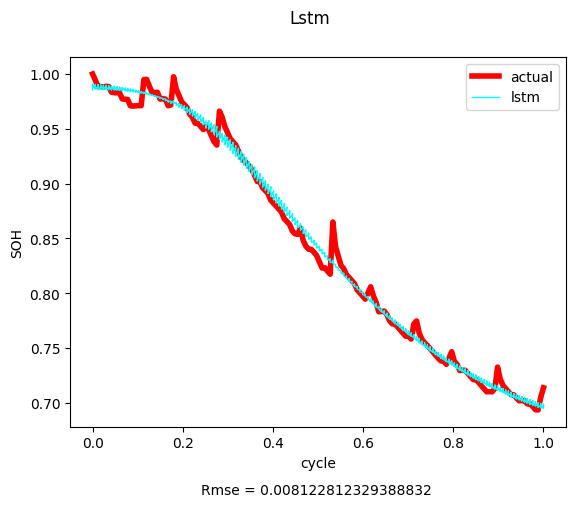

0.008122812329388832


In [14]:
plt.plot(X_test["cycle"],y_test,color='red',label='actual',linewidth=4)
plt.plot(X_test["cycle"],y_pred_1,color='cyan',label="lstm",linewidth=1)
plt.xlabel("cycle")
plt.ylabel("SOH")
rmse="Rmse = "+str(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))
plt.figtext(0.33, -0.03, rmse, fontsize=10)
plt.legend(loc="upper right")
plt.suptitle("Lstm")
plt.show()
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred_1)))